# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW06] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [1]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons
import torch

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [2]:
class Module:
    def forward(self, x):
        raise NotImplementedError()

    def backward(self, d):
        raise NotImplementedError()

    def update(self, alpha):
        pass


class Linear(Module):
    def __init__(self, in_features, out_features):
        self.w = torch.randn((out_features, in_features + 1)) * np.sqrt(2 / (in_features + out_features + 1))
        self.outs_grad = None
        self.ins = None

    def forward(self, x):
        if len(x.size()) == 1:
            x = x.view(1, -1)
        self.ins = torch.cat((x, torch.ones(x.shape[0], 1)), dim=1)
        return self.ins.matmul(self.w.t())

    def backward(self, d):
        self.outs_grad = d
        return d.matmul(self.w)[:, :-1]

    def update(self, alpha):
        self.w -= alpha * self.outs_grad.t().matmul(self.ins)


class ReLU(Module):
    def __init__(self):
        self.ins = None

    def forward(self, x):
        if len(x.size()) == 1:
            x = x.view(1, -1)
        self.ins = x
        return x * (x > 0)

    def backward(self, d):
        return d * (self.ins > 0)


class Softmax(Module):
    def __init__(self):
        self.ins = None
        self.outs = None

    def forward(self, x):
        if len(x.size()) == 1:
            x = x.view(1, -1)
        self.ins = x
        exps = torch.exp(x)
        sums = exps.sum(dim=1).view(-1, 1).expand_as(x)
        self.outs = exps / sums
        return self.outs

    def backward(self, d):
        x1 = -(d * self.outs).sum(dim=1)
        return self.outs * (x1.view(-1, 1).expand_as(self.outs) + d)

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [8]:
class MLPClassifier:
    def __init__(self, modules, epochs=40, alpha=0.01, batch_size=2000):
        self.modules = modules
        self.epochs = epochs
        self.alpha = alpha
        self.batch_size = batch_size

    def forwarding(self, batch):
        for module in self.modules:
            batch = module.forward(batch)
        return batch

    def backwarding(self, d):
        for module in self.modules[::-1]:
            d = module.backward(d)

    def updating(self):
        for module in self.modules:
            module.update(self.alpha)

    def fit(self, X, y):
        X = torch.Tensor(X)
        y = torch.Tensor(y)
        for i in range(self.epochs):

            inds = np.arange(X.size()[0])
            np.random.shuffle(inds)
            X = X[inds]
            y = y[inds]

            Xs = torch.split(X, X.size()[0] // self.batch_size + 1)
            ys = torch.split(y, y.size()[0] // self.batch_size + 1)

            for X_b, y_b in zip(Xs, ys):
                outs = self.forwarding(X_b)
                d = torch.zeros(outs.size())
                for i in range(X_b.size()[0]):
                    d[i][int(y_b[i])] = -1 / outs[i][int(y_b[i])]
                self.backwarding(d)
                self.updating()

    def predict_proba(self, X):
        X = torch.Tensor(X)
        return self.forwarding(X)

    def predict(self, X):
        X = torch.Tensor(X)
        p = self.predict_proba(X)
        return np.array(np.argmax(p, axis=1))

In [9]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
])

X = np.random.randn(50, 4)
y = [(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X]
p.fit(X, y)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [10]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)

best_acc = 0
for _ in range(25):
    p = MLPClassifier([
        Linear(2, 64),
        ReLU(),
        Linear(64, 64),
        ReLU(),
        Linear(64, 2),
        Softmax()
    ])

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 1.0


In [11]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc = 0
for _ in range(25):
    p = MLPClassifier([
        Linear(2, 64),
        ReLU(),
        Linear(64, 64),
        ReLU(),
        Linear(64, 3),
        Softmax()
    ])
    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.9625


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [17]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("/datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("/datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())



0it [00:00, ?it/s]

  0%|                                                                                    | 0/170498071 [00:00<?, ?it/s]

  0%|                                                                      | 8192/170498071 [00:00<41:06, 69113.70it/s]

  0%|                                                                     | 40960/170498071 [00:00<32:09, 88321.87it/s]

  0%|                                                                   | 106496/170498071 [00:01<24:09, 117572.93it/s]

  0%|                                                                   | 172032/170498071 [00:01<18:42, 151715.80it/s]

  0%|                                                                   | 303104/170498071 [00:01<13:58, 202924.97it/s]

  0%|▏                                                                  | 565248/170498071 [00:01<10:10, 278544.79it/s]

  1%|▍                                                                  | 974848/170498071 [00:01<07:18, 386588.78it/s]

  1%|▌    

 21%|█████████████▋                                                  | 36388864/170498071 [00:09<00:52, 2559099.04it/s]

 22%|█████████████▊                                                  | 36667392/170498071 [00:09<00:53, 2517693.57it/s]

 22%|█████████████▊                                                  | 36937728/170498071 [00:09<01:03, 2094383.09it/s]

 22%|█████████████▉                                                  | 37175296/170498071 [00:10<01:02, 2134743.22it/s]

 22%|██████████████                                                  | 37404672/170498071 [00:10<01:05, 2040175.41it/s]

 22%|██████████████                                                  | 37625856/170498071 [00:10<01:07, 1978862.14it/s]

 22%|██████████████▏                                                 | 37838848/170498071 [00:10<01:05, 2011974.53it/s]

 22%|██████████████▎                                                 | 38068224/170498071 [00:10<01:03, 2088290.99it/s]

 23%|██████████████▍            

 38%|████████████████████████▍                                       | 65036288/170498071 [00:18<00:39, 2693492.82it/s]

 38%|████████████████████████▌                                       | 65396736/170498071 [00:18<00:38, 2753534.90it/s]

 39%|████████████████████████▋                                       | 65822720/170498071 [00:18<00:34, 3069760.09it/s]

 39%|████████████████████████▊                                       | 66191360/170498071 [00:18<00:40, 2599166.81it/s]

 39%|████████████████████████▉                                       | 66502656/170498071 [00:18<00:47, 2199266.46it/s]

 39%|█████████████████████████                                       | 66772992/170498071 [00:18<00:45, 2269118.79it/s]

 39%|█████████████████████████▏                                      | 67035136/170498071 [00:19<00:48, 2132897.37it/s]

 39%|█████████████████████████▋                                       | 67280896/170498071 [00:19<01:53, 913372.13it/s]

 40%|█████████████████████████▌ 

 54%|██████████████████████████████████▊                             | 92889088/170498071 [00:26<00:23, 3240227.37it/s]

 55%|███████████████████████████████████                             | 93323264/170498071 [00:26<00:22, 3502609.96it/s]

 55%|███████████████████████████████████▏                            | 93757440/170498071 [00:26<00:20, 3689340.07it/s]

 55%|███████████████████████████████████▎                            | 94216192/170498071 [00:26<00:19, 3862054.18it/s]

 56%|███████████████████████████████████▌                            | 94658560/170498071 [00:26<00:18, 3994129.58it/s]

 56%|███████████████████████████████████▋                            | 95076352/170498071 [00:27<00:19, 3862253.96it/s]

 56%|███████████████████████████████████▊                            | 95494144/170498071 [00:27<00:19, 3937248.77it/s]

 56%|███████████████████████████████████▉                            | 95903744/170498071 [00:27<00:18, 3970495.57it/s]

 57%|███████████████████████████

 71%|████████████████████████████████████████████▉                  | 121716736/170498071 [00:34<00:19, 2473546.20it/s]

 72%|█████████████████████████████████████████████                  | 122118144/170498071 [00:34<00:17, 2793027.23it/s]

 72%|█████████████████████████████████████████████▎                 | 122560512/170498071 [00:34<00:15, 3074994.62it/s]

 72%|█████████████████████████████████████████████▍                 | 122970112/170498071 [00:34<00:14, 3297849.75it/s]

 72%|█████████████████████████████████████████████▌                 | 123461632/170498071 [00:34<00:12, 3645411.27it/s]

 73%|█████████████████████████████████████████████▊                 | 124002304/170498071 [00:34<00:11, 4039938.42it/s]

 73%|█████████████████████████████████████████████▉                 | 124477440/170498071 [00:34<00:10, 4215441.50it/s]

 73%|██████████████████████████████████████████████▏                | 125018112/170498071 [00:35<00:10, 4481921.70it/s]

 74%|███████████████████████████

 91%|█████████████████████████████████████████████████████████▍     | 155287552/170498071 [00:42<00:04, 3764079.12it/s]

 91%|█████████████████████████████████████████████████████████▌     | 155680768/170498071 [00:42<00:04, 3392295.02it/s]

 92%|█████████████████████████████████████████████████████████▋     | 156041216/170498071 [00:42<00:04, 3180732.53it/s]

 92%|█████████████████████████████████████████████████████████▊     | 156377088/170498071 [00:42<00:05, 2823915.47it/s]

 92%|█████████████████████████████████████████████████████████▉     | 156737536/170498071 [00:42<00:04, 3005921.21it/s]

 92%|██████████████████████████████████████████████████████████     | 157130752/170498071 [00:42<00:04, 3210765.31it/s]

 92%|██████████████████████████████████████████████████████████▏    | 157556736/170498071 [00:42<00:03, 3444841.14it/s]

 93%|██████████████████████████████████████████████████████████▍    | 157999104/170498071 [00:42<00:03, 3662808.17it/s]

 93%|███████████████████████████

Files already downloaded and verified




170500096it [01:00, 3506381.62it/s]                                                                                    

### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [31]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.linear1 = nn.Linear(16 * 5 * 5, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.softmax(self.linear3(x))
        return x
        
def calculate_loss(X, y, model):
    return F.cross_entropy(model.forward(X), y)

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [34]:
def train(model, epochs=50):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [35]:
model = Model().to(device)
train_l, test_l = train(model)

Epoch 0 | Train loss 2.2738408158874512 | Test loss 2.2188154674530027
Epoch 1 | Train loss 2.1824909046936036 | Test loss 2.145561333847046
Epoch 2 | Train loss 2.1328487299346923 | Test loss 2.1125476188659666
Epoch 3 | Train loss 2.105009841995239 | Test loss 2.087848307800293
Epoch 4 | Train loss 2.085315840988159 | Test loss 2.0674091873168945
Epoch 5 | Train loss 2.0728449227905275 | Test loss 2.0594405685424806
Epoch 6 | Train loss 2.0599570733642576 | Test loss 2.055662368774414
Epoch 7 | Train loss 2.049562091598511 | Test loss 2.0416516605377195
Epoch 8 | Train loss 2.0428573064422606 | Test loss 2.0442844177246093
Epoch 9 | Train loss 2.040713670120239 | Test loss 2.030572761917114
Epoch 10 | Train loss 2.0263272481536867 | Test loss 2.02403299407959
Epoch 11 | Train loss 2.018456377410889 | Test loss 2.016851594543457
Epoch 12 | Train loss 2.0141104106140135 | Test loss 2.0130614856719973
Epoch 13 | Train loss 2.0089394708251955 | Test loss 2.005411833190918
Epoch 14 | Trai

Построим график функции потерь

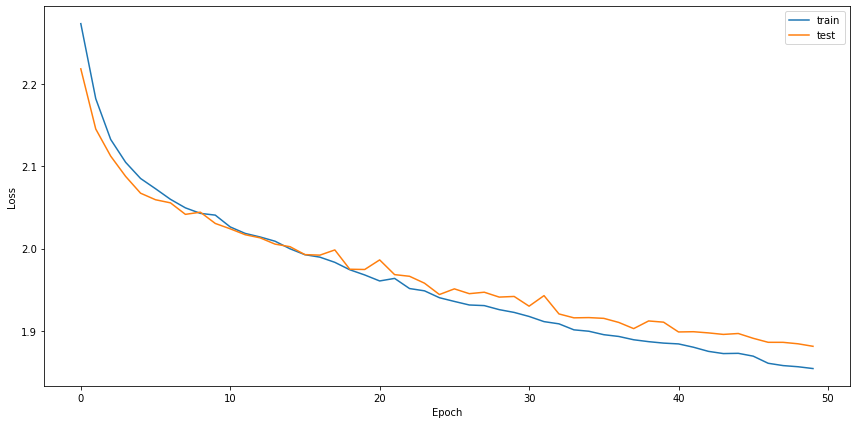

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [37]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.581
Precision [0.63975155 0.69306931 0.46777547 0.39839034 0.55808081 0.48915187
 0.6214539  0.6772009  0.62884927 0.62228797]
Recall [0.618 0.7   0.45  0.396 0.442 0.496 0.701 0.6   0.776 0.631]
Mean Precision 0.579601139415165
Mean Recall 0.5810000000000001
